# Data Collection

In [ ]:
!pip install tensorflow 

In [ ]:
!pip install opencv-python matplotlib

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import imghdr
from matplotlib import pyplot as plt

### Since used images are from google we need to check if they are in correct form. Cell below automatically will find and delete files with wrong extension

In [8]:
i_exts = ['jpeg','jpg','png','bmp']

In [9]:
for folder in os.listdir('images'):
    for image in os.listdir(os.path.join('images', folder)):
        path = os.path.join('images', folder, image)
        try:
            ext = imghdr.what(path)
            if ext not in i_exts:
                os.remove(path)
                print(f'Deleting picture: {path}')
        except Exception as e:
            print(f'Problem with image {path}')

### Simply we loop thorugh the folders to import images, put them in an array and give them correct label

In [10]:
count = 0
images = []
classNumber = []
for x in range(0, 3):
    list_img = os.listdir('images'+'/'+str(count))
    for y in list_img:
        curImg = cv2.imread('images' +"/" + str(count) + "/" + y)
        curImg = tf.image.resize(curImg,(128,128))
        images.append(curImg)
        classNumber.append(count)
    print(f"Importing class {count}")
    count += 1
print(" ")
    
images = np.array(images)
classNumber = np.array(classNumber)

Importing class 0
Importing class 1
Importing class 2
 


# Data Preprocessing

### Splitting data into train, test and validation set, then turning labels of training and validation sets into categorical values, since model needs it in this form to work

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, classNumber, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1572, 128, 128, 3) (1572,)
(393, 128, 128, 3) (393,)
(219, 128, 128, 3) (219,)


In [13]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_val = tf.keras.utils.to_categorical(y_val, 3)

### Function to add values into graph, then simple bar grraph to show how many images of each category we have

In [14]:
def addNumbers(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center')

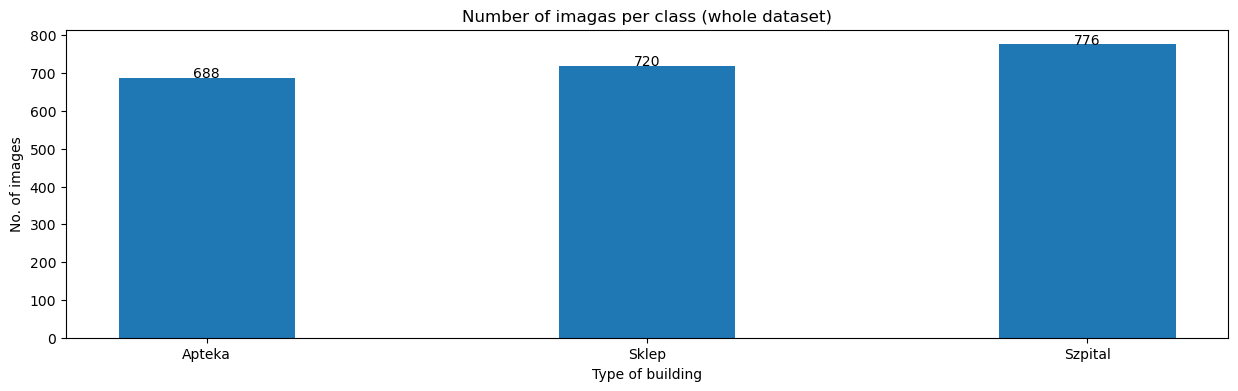

In [15]:
unique, counts = np.unique(classNumber, return_counts=True)
Names = ['Apteka','Sklep','Szpital']
fig = plt.figure(figsize = (15,4))
plt.bar(Names, counts,  width = 0.4)
plt.xlabel("Type of building")
plt.ylabel("No. of images")
plt.title("Number of imagas per class (whole dataset)")
addNumbers(Names,counts)
plt.show()

### Function to scale and flip the image in random fashion so model can learn better

In [16]:
def preprocesing(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = image/255
    return image

In [17]:
X_train = np.array(list(map(preprocesing,X_train)))
X_val = np.array(list(map(preprocesing,X_val)))
X_test = np.array(list(map(preprocesing,X_test)))                        

### We check if evertyhing is correct

In [18]:
print(f'Max value: {X_train.max()}, Min value: {X_train.min()}')
print(f'Max value: {X_val.max()}, Min value: {X_val.min()}')
print(f'Max value: {X_test.max()}, Min value: {X_test.min()}')

Max value: 1.0, Min value: 0.0
Max value: 1.0, Min value: 0.0
Max value: 1.0, Min value: 0.0


In [19]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1572, 128, 128, 3) (1572, 3)
(393, 128, 128, 3) (393, 3)
(219, 128, 128, 3) (219,)


# Model Creation and Traning

### Using convolutional and pooling layers, we create 3 parts of the model, then we use flatten layer to flatten the data to pass it to dense layers. Since we are predicting 3 classes, we use softmax with 3 output neurons

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    
    Conv2D(32, (3, 3), 1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D(),
    
    Conv2D(64, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

### Using Model Checkpoint we save best model into model folder then we train it

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', mode='max',save_best_only=True, filepath = r"model/best_model.h5", verbose = 1)

In [23]:
history = model.fit(X_train, y_train, batch_size  = 16, epochs = 10, validation_data = (X_val,y_val), callbacks = [mc])

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9548
Epoch 1: val_accuracy improved from -inf to 0.97710, saving model to model\best_model.h5
99/99 [==============================] - 30s 300ms/step - loss: 0.1905 - accuracy: 0.9548 - val_loss: 0.0642 - val_accuracy: 0.9771
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9835
Epoch 2: val_accuracy improved from 0.97710 to 0.99237, saving model to model\best_model.h5
99/99 [==============================] - 29s 291ms/step - loss: 0.0592 - accuracy: 0.9835 - val_loss: 0.0407 - val_accuracy: 0.9924
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9981
Epoch 3: val_accuracy did not improve from 0.99237
99/99 [==============================] - 27s 269ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0368 - val_accuracy: 0.9898
Epoch 4/10
99/99 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9

### We plot learing curves

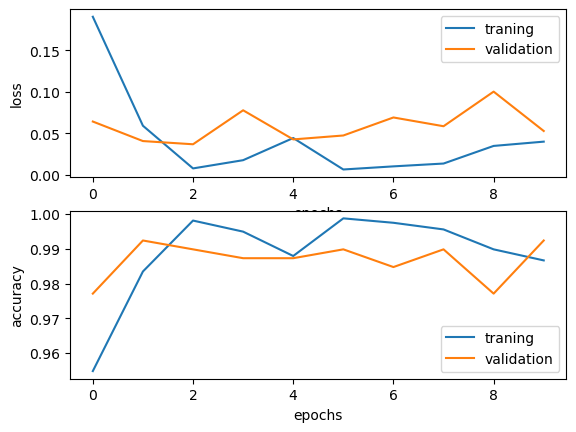

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

### Then we learn model so we can use it to make predicitons

# Predictions and Testing

In [21]:
from tensorflow.keras.models import load_model
model = load_model(r'model/best_model.h5')

In [22]:
predictions = list(np.argmax(model.predict(X_test), axis=-1))

7/7 [==============================] - 1s 108ms/step


### Function to give names to our predictions

In [23]:
def Name(x):
    if x == 0: return 'Apteka'
    elif x == 1: return 'Sklep'
    else: return 'Szpital'

### We plot random images from test set to check if predictions are correct

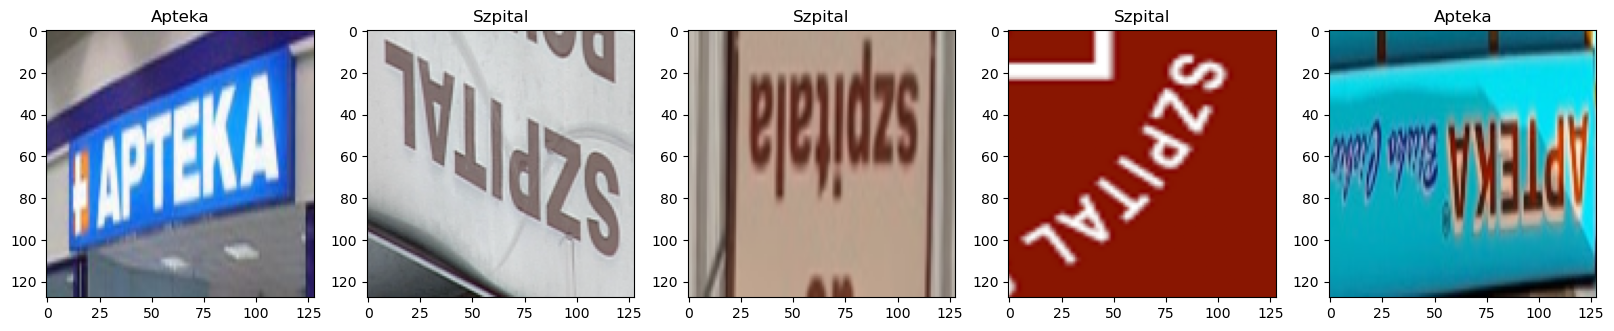

In [24]:
import random
r_nr = random.randint(0,len(X_test)+1)
fig, ax = plt.subplots(ncols = 5, figsize = (20,20))
for i, image in enumerate(X_test[r_nr:r_nr+5]):
    ax[i].imshow(image)
    ax[i].title.set_text(Name(predictions[r_nr+i]))
    

### Then using sklearn, we calculate metrics and generate classification report

In [25]:
from sklearn.metrics import precision_score,recall_score, balanced_accuracy_score
print(f'Metrics for the model: Precision: {precision_score(y_test, predictions, average = "micro")}, Recall: {recall_score(y_test, predictions, average = "micro")} , Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}')

Metrics for the model: Precision: 0.9954337899543378, Recall: 0.9954337899543378 , Balanced Accuracy: 0.9948717948717949


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['Apteka','Sklep','Szpital']))

              precision    recall  f1-score   support

      Apteka       0.99      1.00      0.99        75
       Sklep       1.00      0.98      0.99        65
     Szpital       1.00      1.00      1.00        79

    accuracy                           1.00       219
   macro avg       1.00      0.99      1.00       219
weighted avg       1.00      1.00      1.00       219



### We plot confusion matrix

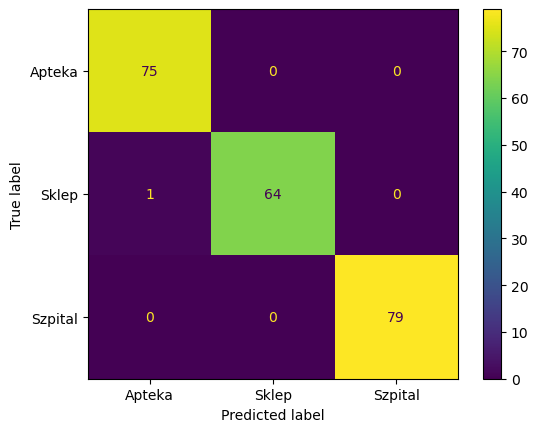

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Apteka','Sklep','Szpital'])
cmd.plot()
plt.show()

# Real-time Predictions

### Using OpenCV we can test our model in real time, first we process readings from camera, then we pass the image to the model to predict the class. If model is more then 80% sure what class to predcict, it will show it on the screen

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    
    _, image = cap.read()
    
    img = np.asarray(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    img = img.reshape(1,128,128,3)
    
    prediction = model.predict(img/255)
    prediction_prob = np.amax(prediction)
    
    if prediction_prob > 0.8:
        cv2.putText(image, str(Name(np.argmax(prediction, axis=-1))), (20,35),cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0),2,cv2.LINE_AA)
        cv2.putText(image,'Probability '+str(round(prediction_prob*100,2) )+'%', (20,75),cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0),2,cv2.LINE_AA)
    
    cv2.imshow('Test Window', image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

### As we could see model works really well, it get accuracy of 99.2% which is really high, to improve it we could play with grayscale or other image proccesing functions, but in this case it wasn't necessary